### 모델링을 위한 기본 전처리
- 목적
    - 모델링을 위한 기본 전처리
- 핵심
    - SQL(BigQuery)로 가능한 부분은 SQL에서 => 로컬 파이썬 보다 성능이 좋을 수 있음. 단, 데이터 IO도 생각해야 함
    - SQL에서 힘든 전처리는 Python에서! => Label Encoding, One Hot Encoding 등
- 다루는 내용
    - `시간 관련 전처리`
        - DATETIME에서 MONTH, HOUR, WEEKDAY 등 추출
        - BigQuery vs Python
    - `BigQuery GIS`로 Reverse Geocoding
        - 좌표 => zip_code로 변환
    - `Categorical 데이터 전처리`
        - One Hot Encoding
        - Label Encoding
    - `Train / Test Split`

In [137]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
warnings.filterwarnings('ignore')

PROJECT_ID='big-query-project-mg' 

### 시간 관련 전처리
- 1) BigQuery에서 처리하기
    - DATETIME_TRUNC : 데이터 자르기
    - EXTRACT 함수를 사용하면 MONTH, WEEK, DAY, HOUR 등을 쉽게 추출 가능 
        - [EXTRACT 공식 문서](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions?hl=ko#extract)
    - FORMAT_DATETIME 함수를 사용하면 요일을 추출할 수 있음(단, 1이 월요일 => Pandas에선 0이 월요일)
        - [FORMAT_DATETIME 공식 문서](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions?hl=ko#format_datetime)

In [138]:
%%time
extract_query = """
SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
FROM (
    SELECT 
        DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
        count(*) AS cnt
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
    WHERE EXTRACT(MONTH from pickup_datetime) = 1
    GROUP BY pickup_hour
)
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=extract_query, dialect='standard', project_id=PROJECT_ID)

Wall time: 2.05 s


In [139]:
df.tail()

,pickup_hour,cnt,month,day,weekday,hour,is_weekend
739,2015-01-31 19:00:00,32436,1,31,5,19,1
740,2015-01-31 20:00:00,27555,1,31,5,20,1
741,2015-01-31 21:00:00,27477,1,31,5,21,1
742,2015-01-31 22:00:00,29862,1,31,5,22,1
743,2015-01-31 23:00:00,29856,1,31,5,23,1


In [140]:
%%time
extract_query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) -1 AS weekday, # Python과 맞추기 위해 -1
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    count(*) AS cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=extract_query, dialect='standard', project_id=PROJECT_ID)

Wall time: 1.84 s


In [142]:
df.tail()

,pickup_hour,month,day,weekday,hour,is_weekend,cnt
739,2015-01-31 19:00:00,1,31,5,19,1,32436
740,2015-01-31 20:00:00,1,31,5,20,1,27555
741,2015-01-31 21:00:00,1,31,5,21,1,27477
742,2015-01-31 22:00:00,1,31,5,22,1,29862
743,2015-01-31 23:00:00,1,31,5,23,1,29856


- 2) Python에서 처리하기
    - Pandas datetime 처리하기
    - `pd.to_datetime`으로 datetime 변환 후, df[col].dt.xxx 로 추출

In [143]:
extract_query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
    count(*) AS cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=extract_query, dialect='standard', project_id=PROJECT_ID)

In [144]:
df.head()

,pickup_hour,cnt
0,2015-01-01 00:00:00,28312
1,2015-01-01 01:00:00,31707
2,2015-01-01 02:00:00,28068
3,2015-01-01 03:00:00,24288
4,2015-01-01 04:00:00,17081


In [145]:
df.info

<bound method DataFrame.info of             pickup_hour    cnt
0   2015-01-01 00:00:00  28312
1   2015-01-01 01:00:00  31707
2   2015-01-01 02:00:00  28068
3   2015-01-01 03:00:00  24288
4   2015-01-01 04:00:00  17081
..                  ...    ...
739 2015-01-31 19:00:00  32436
740 2015-01-31 20:00:00  27555
741 2015-01-31 21:00:00  27477
742 2015-01-31 22:00:00  29862
743 2015-01-31 23:00:00  29856

[744 rows x 2 columns]>

In [146]:
df['month'] = df['pickup_hour'].dt.month
df['day'] = df['pickup_hour'].dt.day
df['weekday'] = df['pickup_hour'].dt.weekday
df['hour'] = df['pickup_hour'].dt.hour
df['is_weekend'] = (df['pickup_hour'].dt.weekday // 5 == 1).astype(int)

In [147]:
df.tail()

,pickup_hour,cnt,month,day,weekday,hour,is_weekend
739,2015-01-31 19:00:00,32436,1,31,5,19,1
740,2015-01-31 20:00:00,27555,1,31,5,20,1
741,2015-01-31 21:00:00,27477,1,31,5,21,1
742,2015-01-31 22:00:00,29862,1,31,5,22,1
743,2015-01-31 23:00:00,29856,1,31,5,23,1


- 정리 : SQL(BigQuery)로 가능한 부분은 SQL에서 => 로컬 파이썬 보다 성능이 좋을 수 있음. 단, 데이터 IO도 생각해야 함


In [148]:
df.head(3)

,pickup_hour,cnt,month,day,weekday,hour,is_weekend
0,2015-01-01 00:00:00,28312,1,1,3,0,0
1,2015-01-01 01:00:00,31707,1,1,3,1,0
2,2015-01-01 02:00:00,28068,1,1,3,2,0


### `BigQuery GIS`로 Reverse Geocoding
- 좌표 => zip_code로 변환
- BigQuery의 `bigquery-public-data.geo_us_boundaries.zip_codes` 참고
- ST_CONTAINS 함수로 추출 가능

In [149]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""
# 참고: Fastcampus 강의
base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

INFO - pandas_gbq.gbq - Total time taken 8.16 s.
Finished at 2021-02-07 17:52:45.


Wall time: 8.17 s


In [150]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
87015,10012,2015-01-31 23:00:00,1,31,5,23,1,1314
87016,11219,2015-01-31 23:00:00,1,31,5,23,1,1
87017,11355,2015-01-31 23:00:00,1,31,5,23,1,1
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1
87019,11385,2015-01-31 23:00:00,1,31,5,23,1,2


### `Categorical 데이터 전처리`
- One Hot Encoding

In [152]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [153]:
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
oh_feature_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+enc.categories_[0])], axis=1)
oh_feature_df.head(3)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,11215,2015-01-01,1,1,3,0,0,97,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10172,2015-01-01,1,1,3,0,0,26,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10451,2015-01-01,1,1,3,0,0,15,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Label Encoding

In [154]:
# le = LabelEncoder()
# le.fit(base_df['zip_code'])
# base_df['zip_code_le'] = le.transform(base_df['zip_code'])

- Linear Regression에선 One Hot Encoding을 사용하겠습니다 :)

### Train and Test Split
- 시계열 데이터는 Random Sampling을 하면 안됨
- Train엔 과거 데이터, Test엔 (과거 대비) 미래 데이터가 있어야 함
    - 만약 Train에 미래 데이터가 있다면? 미래를 보고 과거를 예측한 꼴
    - 실제로 사용할 땐 과거 데이터 기반으로 미래 데이터를 예측

In [155]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    # 기준점을 임의로 설정한다는 점에서 아래와 다름 ( 유동적으로 하는것이 적절=> 아래 def 사용)
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

- 위 방법은 명시적으로 date를 지정하는 방법이 마음에 들지 않을수도 있음
    - 이럴 경우 Dataframe의 시간 데이터를 마지막 1주치만 Test로 지정할 수 있음

In [156]:
def split_train_and_test_period(df, period):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    period : train/test 기준 일
    """
    criteria = (max(df['pickup_hour']) - pd.Timedelta(days=period)).date() #임계값 설정
    train_df = df[df['pickup_hour'] < criteria]
    test_df = df[df['pickup_hour'] >= criteria]
    return train_df, test_df

### Train / Test 나누기

In [157]:
train_df, test_df = split_train_and_test(oh_feature_df, '2015-01-24')

In [158]:
train_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,11215,2015-01-01,1,1,3,0,0,97,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10172,2015-01-01,1,1,3,0,0,26,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10451,2015-01-01,1,1,3,0,0,15,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10018,2015-01-01,1,1,3,0,0,631,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10038,2015-01-01,1,1,3,0,0,158,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
test_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
65118,10031,2015-01-24,1,24,5,0,1,41,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65119,11377,2015-01-24,1,24,5,0,1,28,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65120,11103,2015-01-24,1,24,5,0,1,34,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65121,10035,2015-01-24,1,24,5,0,1,34,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65122,11434,2015-01-24,1,24,5,0,1,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']
# del train_df['zip_code_le']
# del test_df['zip_code_le']

In [161]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,1,1,3,0,0,97,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,3,0,0,26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
y_train = train_df.pop('cnt')
x_train = train_df.copy()

In [163]:
y_test = test_df.pop('cnt')
x_test = test_df.copy()

In [164]:
x_train

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65113,1,23,4,23,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65114,1,23,4,23,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65115,1,23,4,23,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65116,1,23,4,23,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
y_train

0         97
1         26
2         15
3        631
4        158
        ... 
65113     12
65114      5
65115      2
65116      2
65117      3
Name: cnt, Length: 65118, dtype: int64

In [166]:
x_test

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65121,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65122,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,1,31,5,23,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87016,1,31,5,23,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87017,1,31,5,23,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87018,1,31,5,23,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
y_test

65118      41
65119      28
65120      34
65121      34
65122       2
         ... 
87015    1314
87016       1
87017       1
87018       1
87019       2
Name: cnt, Length: 21902, dtype: int64

## 베이스라인 모델 : 단순 회귀
- 목적
    - 비교를 위한 베이스라인 모델 생성
    - 베이스라인 : 비교 대상이 될 모델
- 핵심
    - Target 값의 분포를 찍어보고 => 몰려있다면 Log
    - 베이스라인이기 때문에 성능이 낮다고 좌절 금지
- 다루는 내용
    - `Target` 분포 확인
    - Simple Linear Regression


In [168]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'



### 전처리

In [419]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

INFO - pandas_gbq.gbq - Total time taken 9.16 s.
Finished at 2021-02-07 19:14:18.


Wall time: 9.16 s


In [420]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)

In [421]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Linear Regerssion
- Baseline 모델
    - 작업한 모델 중 제일 성능이 낮을 모델, 비교 대상 

### Target 분포 확인

In [172]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,11215,2015-01-01,1,1,3,0,0,97
1,10172,2015-01-01,1,1,3,0,0,26
2,10451,2015-01-01,1,1,3,0,0,15
3,10018,2015-01-01,1,1,3,0,0,631
4,10038,2015-01-01,1,1,3,0,0,158


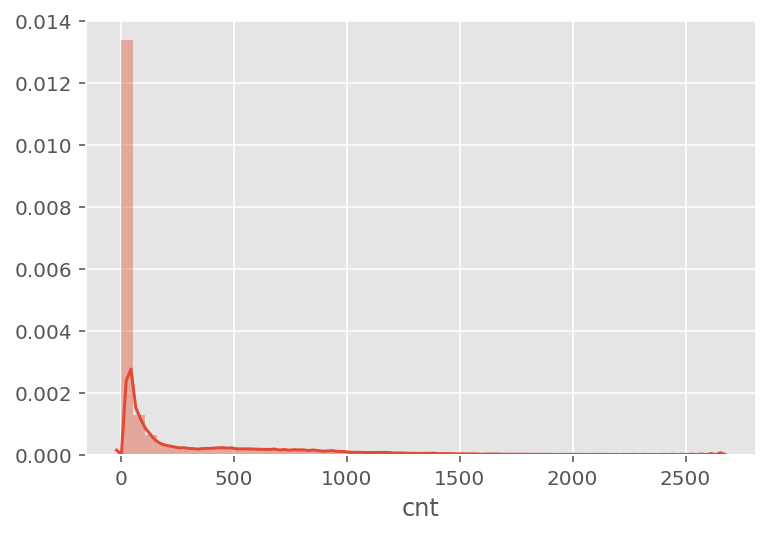

In [173]:
# 전체 분포
sns.distplot(base_df['cnt']);

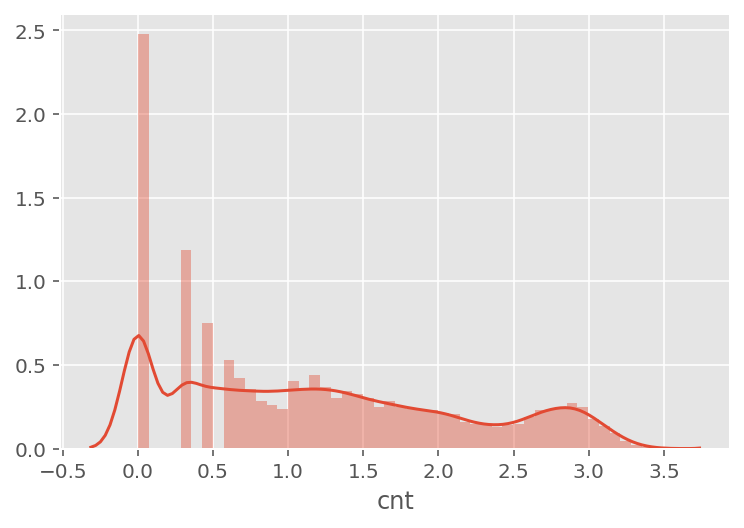

In [174]:
# 전체 분포 log화
sns.distplot(np.log10(base_df['cnt']));

### Widget으로 파악

In [175]:
def visualize_dist_by_zipcode(df, log=False):
    def view_images(zip_code):
        if log:
            data = np.log10(df.loc[df['zip_code'] == str(zip_code)]['cnt'])
        else:
            data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        ax = sns.distplot(data);
        ax.set_title(f'log is {log}, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

In [176]:
visualize_dist_by_zipcode(ohe_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

In [177]:
visualize_dist_by_zipcode(base_df, log=True)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

- 그냥 한번에 보도록 함수 수정

In [178]:
def visualize_dist_by_zipcode_at_the_same_time(df):
    def view_images(zip_code):
        fig, axs = plt.subplots(ncols=2, figsize=(15,5))

        raw_data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        log_data = np.log10(raw_data)
        ax1 = sns.distplot(raw_data, ax=axs[0]);
        ax2 = sns.distplot(log_data, ax=axs[1]);
        ax1.set_title(f'log is False, zip_code : {zip_code}')
        ax2.set_title(f'log is True, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

In [179]:
visualize_dist_by_zipcode_at_the_same_time(base_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

- log_cnt 생성

In [180]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

### Train / Test 나누기

In [181]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [182]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
65113,10032,2015-01-23 23:00:00,1,23,4,23,0,12,1.079181
65114,10173,2015-01-23 23:00:00,1,23,4,23,0,5,0.698970
65115,11435,2015-01-23 23:00:00,1,23,4,23,0,2,0.301030
65116,10605,2015-01-23 23:00:00,1,23,4,23,0,2,0.301030
65117,11218,2015-01-23 23:00:00,1,23,4,23,0,3,0.477121


In [183]:
test_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
87015,10012,2015-01-31 23:00:00,1,31,5,23,1,1314,3.118595
87016,11219,2015-01-31 23:00:00,1,31,5,23,1,1,0.000000
87017,11355,2015-01-31 23:00:00,1,31,5,23,1,1,0.000000
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1,0.000000
87019,11385,2015-01-31 23:00:00,1,31,5,23,1,2,0.301030


- 사용하지 않을 컬럼 삭제

In [184]:
del train_df['pickup_hour']
del test_df['pickup_hour']

In [185]:
train_df.head(2)

,zip_code,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,11215,1,1,3,0,0,97,1.986772
1,10172,1,1,3,0,0,26,1.414973


In [186]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

In [187]:
x_train = train_df.copy()
x_test = test_df.copy()

### Simple Regression
- One Hot Encoding 없이 그냥

In [189]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([1.53660443, 0.37527524, 0.61168252, ..., 0.71999371, 0.84509975,
       0.6941097 ])

In [190]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [191]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [192]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,428.415375,126.535552,95916.687733


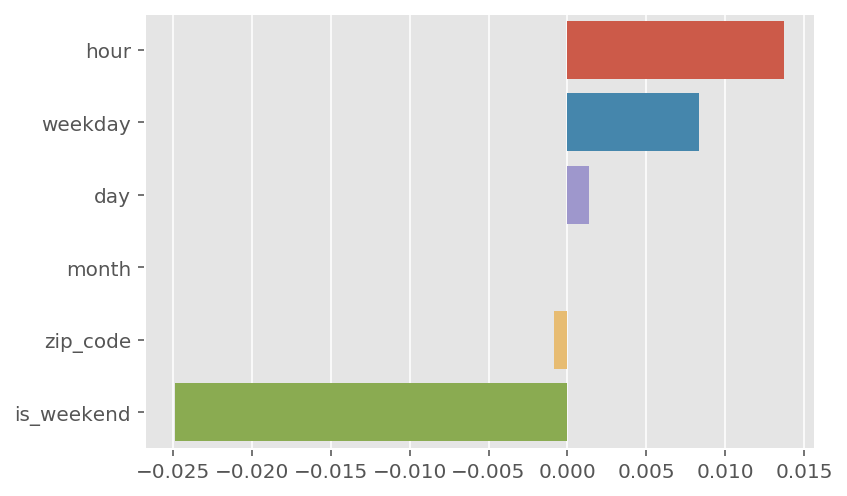

In [193]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

### One Hot Encoding

- One Hot Encoding을 사용해 Regression

In [194]:
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])
train_df, test_df = split_train_and_test(ohe_df, '2015-01-24')
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

x_train = train_df.copy()
x_test = test_df.copy()

In [195]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([1.16033936, 1.00359726, 0.88969803, ..., 0.28488922, 0.31773376,
       0.43917465])

In [196]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [197]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred_log,pred_reverse,real_log,real_raw
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.160339,14.465697,1.612784,41
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.003597,10.083174,1.447158,28
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.889698,7.757076,1.531479,34
65121,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.302738,20.078820,1.531479,34
65122,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.032970,0.926893,0.301030,2


In [198]:
test_df.head(3)

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred_log,pred_reverse,real_log,real_raw
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.160339,14.465697,1.612784,41
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.003597,10.083174,1.447158,28
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.889698,7.757076,1.531479,34


In [199]:
# inf를 제외하기 위한 전처리
test_df = test_df[np.isfinite(test_df).all(1)]

In [200]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,244.719476,66.944379,27022.012128


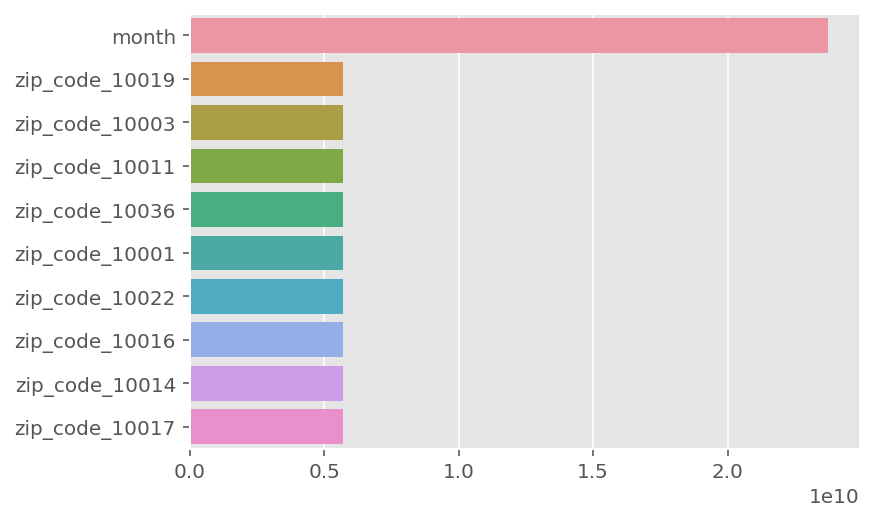

In [201]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

In [202]:
#!pip3 install sacred

## XGBoost Regerssor
- 목적
    - XGBoost sklearn API 활용
    - Classification이 아닌 Regressor 사용하기
- 참고 자료
    - https://brunch.co.kr/@snobberys/137
    - https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf

In [203]:
# !pip install xgboost

In [204]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from xgboost import XGBRegressor
import json
import numpy as np

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'


In [205]:
ex = Experiment('nyc-demand-prediction', interactive=True)

# experiment_dir가 없으면 폴더 생성하고 FileStorageObserver로 저장
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

In [206]:
experiment_dir

'./experiments'

### 전처리

In [207]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

INFO - pandas_gbq.gbq - Total time taken 11.79 s.
Finished at 2021-02-07 17:54:13.


Wall time: 11.8 s


### 데이터 전처리
- One Hot Encoding이 아닌 Label Encoding

In [208]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [209]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Train / Test 나누기

In [210]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [211]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_le
65113,10278,2015-01-23 23:00:00,1,23,4,23,0,2,65
65114,11210,2015-01-23 23:00:00,1,23,4,23,0,2,199
65115,11233,2015-01-23 23:00:00,1,23,4,23,0,4,221
65116,11365,2015-01-23 23:00:00,1,23,4,23,0,1,239
65117,11229,2015-01-23 23:00:00,1,23,4,23,0,1,217


- 사용하지 않을 컬럼 삭제

In [212]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [213]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,zip_code_le
0,1,1,3,0,0,54,67
1,1,1,3,0,0,971,20


In [214]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [215]:
x_train = train_df.copy()
x_test = test_df.copy()

### 모델링

In [315]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [316]:
@ex.config
def config():
    max_depth=5
    learning_rate=0.1
    n_estimators=100
    n_jobs=-1

In [317]:
@ex.capture
def get_model(max_depth, learning_rate, n_estimators, n_jobs):
    return XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, n_jobs=n_jobs)

In [318]:
@ex.main
def run(_log, _run):
    global xgb_reg, xgb_pred
    xgb_reg = get_model()
    xgb_reg.fit(x_train, y_train_raw)
    xgb_pred = xgb_reg.predict(x_test)
    score = evaluation(y_test_raw, xgb_pred)
    
    _run.log_scalar('model_name', xgb_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [319]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "18"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 538.5201561766145}, 'mae': {'score': 57.67873599873819}, 'mse': {'score': 16512.3302373418}}
INFO - nyc-demand-prediction - Completed after 0:00:01


In [320]:
experiment_result.config

{'n_estimators': 100,
 'n_jobs': -1,
 'max_depth': 5,
 'learning_rate': 0.1,
 'seed': 446786899}

In [321]:
experiment_result.result

{'mape': {'score': 538.5201561766145},
 'mae': {'score': 57.67873599873819},
 'mse': {'score': 16512.3302373418}}

In [229]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(list(json_data['model_name']['values']), columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(list(json_data['metrics']['values'][0]['values']))
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

In [230]:
parsing_output(5)

,model_name,experiment_num,config,0
score,XGBRegressor,5.0,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",NaN
0,NaN,NaN,NaN,m
1,NaN,NaN,NaN,a
2,NaN,NaN,NaN,p
3,NaN,NaN,NaN,e
...,...,...,...,...
63,NaN,NaN,NaN,4
64,NaN,NaN,NaN,1
65,NaN,NaN,NaN,8
66,NaN,NaN,NaN,\r


In [231]:
feat_importances = pd.Series(xgb_reg.feature_importances_, index=x_train.columns)
feat_importances

month          0.000000
day            0.060861
weekday        0.098359
hour           0.186985
is_weekend     0.000000
zip_code_le    0.653795
dtype: float32

## Lightgbm Regerssor
- 목적
    - Lightgbm sklearn API 활용
    - Classification이 아닌 Regressor 사용하기
- 참고 자료
    - [CatBoost vs. Light GBM vs. XGBoost
](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)

In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from lightgbm import LGBMRegressor
import json
import numpy as np

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='big-query-project-mg' # 여기에 여러분들의 프로젝트 ID를 넣어주세요

In [44]:
ex = Experiment('nyc-demand-prediction', interactive=True)

# experiment_dir가 없으면 폴더 생성하고 FileStorageObserver로 저장
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### 전처리

In [45]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (5, 6) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

INFO - pandas_gbq.gbq - Total time taken 9.45 s.
Finished at 2021-02-07 19:11:50.


Wall time: 9.45 s


### 데이터 전처리
- One Hot Encoding이 아닌 Label Encoding

In [46]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [47]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Train / Test 나누기

In [48]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [49]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_le
65113,10037,2015-01-23 23:00:00,1,23,4,23,1,8,34
65114,11365,2015-01-23 23:00:00,1,23,4,23,1,1,239
65115,11356,2015-01-23 23:00:00,1,23,4,23,1,1,231
65116,11229,2015-01-23 23:00:00,1,23,4,23,1,1,217
65117,11370,2015-01-23 23:00:00,1,23,4,23,1,1,244


- 사용하지 않을 컬럼 삭제

In [50]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [51]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,zip_code_le
0,1,1,3,0,0,97,204
1,1,1,3,0,0,26,59


In [52]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [53]:
x_train = train_df.copy()
x_test = test_df.copy()

### 모델링

In [54]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [55]:
@ex.config
def config():
    num_leaves=31
    max_depth=-1
    learning_rate=0.1
    n_estimators=100

In [56]:
@ex.capture
def get_model(num_leaves, max_depth, learning_rate, n_estimators):
    return LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

In [57]:
@ex.main
def run(_log, _run):
    global lgbm_reg, lgbm_pred
    lgbm_reg = get_model()
    lgbm_reg.fit(x_train, y_train_raw)
    lgbm_pred = lgbm_reg.predict(x_test)
    score = evaluation(y_test_raw, lgbm_pred)
    
    _run.log_scalar('model_name', lgbm_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [58]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "6"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 410.6999624575988}, 'mae': {'score': 47.99188513607621}, 'mse': {'score': 13871.771004075947}}
INFO - nyc-demand-prediction - Completed after 0:00:00


In [59]:
experiment_result.config

{'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'seed': 543008714}

In [63]:
experiment_result.result

{'mape': {'score': 410.6999624575988},
 'mae': {'score': 47.99188513607621},
 'mse': {'score': 13871.771004075947}}

In [60]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

In [ ]:
parsing_output(3)

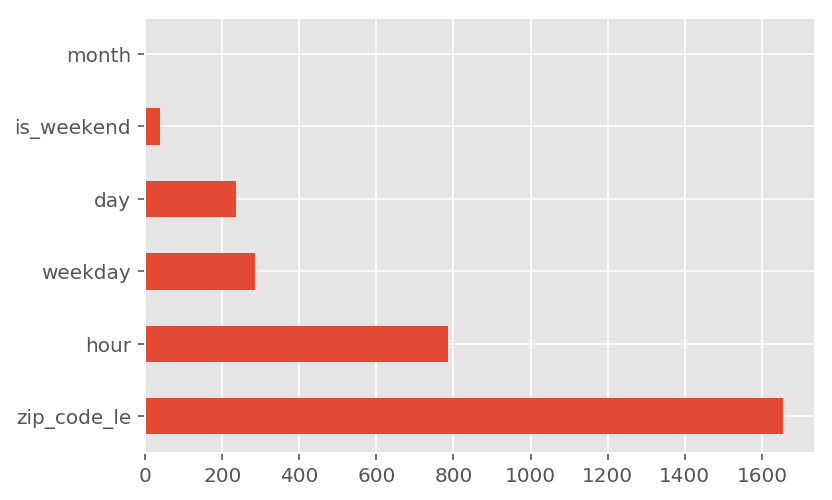

In [21]:
feat_importances = pd.Series(lgbm_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Random Forest Regerssor and Result Analysis
- 목적
    - RandomForest API 활용
    - 모델의 예측값 분석

In [290]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sklearn.ensemble import RandomForestRegressor
import json
from ipywidgets import interact

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'


In [291]:
ex = Experiment('nyc-demand-prediction', interactive=True)

# experiment_dir가 없으면 폴더 생성하고 FileStorageObserver로 저장
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### 전처리

In [292]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

INFO - pandas_gbq.gbq - Total time taken 10.03 s.
Finished at 2021-02-07 18:34:15.


Wall time: 10 s


### 데이터 전처리
- One Hot Encoding이 아닌 Label Encoding

In [295]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [296]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Train / Test 나누기

In [297]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [298]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_le
65113,10278,2015-01-23 23:00:00,1,23,4,23,0,2,65
65114,11210,2015-01-23 23:00:00,1,23,4,23,0,2,199
65115,11233,2015-01-23 23:00:00,1,23,4,23,0,4,221
65116,11365,2015-01-23 23:00:00,1,23,4,23,0,1,239
65117,11229,2015-01-23 23:00:00,1,23,4,23,0,1,217


- 사용하지 않을 컬럼 삭제

In [299]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [300]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,zip_code_le
0,1,1,3,0,0,54,67
1,1,1,3,0,0,971,20


In [301]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [302]:
x_train = train_df.copy()
x_test = test_df.copy()

### 모델링

In [303]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [305]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [306]:
@ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [307]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [308]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "17"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 182.74272076446712}, 'mae': {'score': 34.878727970048395}, 'mse': {'score': 12063.142641311297}}
INFO - nyc-demand-prediction - Completed after 0:00:01


In [309]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 759888859}

In [310]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

In [312]:
experiment_result.result

{'mape': {'score': 182.74272076446712},
 'mae': {'score': 34.878727970048395},
 'mse': {'score': 12063.142641311297}}

In [313]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances

month          0.000000
day            0.028900
weekday        0.031842
hour           0.152162
is_weekend     0.009006
zip_code_le    0.778090
dtype: float64

| XGBoost |  |  |
|:---------- |---------- |:---------- |
|mape|=|score: 538.5201561766145|
|mae|=|score: 57.67873599873819|
|mse|=|score: 16512.3302373418|

| lightGBM Regressor |  |  |
|:---------- |---------- |:---------- |
|mape|=|score: 410.6999624575988|
|mae|=|score: 47.99188513607621|
|mse|=|score: 13871.771004075947|

| RandomForest |  |  |
|:---------- |---------- |:---------- |
|mape|=|score: 182.74272076446712|
|mae|=|score: 34.878727970048395|
|mse|=|score: 12063.142641311297|


### 결과 분석
- 어떤 알고리즘이 제일 성능이 좋았는지?
- RandomForest의 mae : 34, mape : 182, mse : 12063
- test값과 pred 값이 전체적으로 어떠한지?

### Data 복구
- Label Encoding, 삭제한 데이터, Datetime 등 다시 reverse encoding

In [457]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred

In [458]:
test_df['year'] = 2015

In [459]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,zip_code
datetime,,,,,,,,,,
2015-01-31 23:00:00,1,31,5,23,1,277,NaN,2.1,2015,11435
2015-01-31 23:00:00,1,31,5,23,1,243,NaN,1.2,2015,11369
2015-01-31 23:00:00,1,31,5,23,1,97,NaN,2.4,2015,10468
2015-01-31 23:00:00,1,31,5,23,1,202,NaN,1.5,2015,11213
2015-01-31 23:00:00,1,31,5,23,1,244,NaN,3.7,2015,11370


In [460]:
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

In [461]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,zip_code,datetime
datetime,,,,,,,,,,,
2015-01-31 23:00:00,1,31,5,23,1,277,NaN,2.1,2015,11435,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,243,NaN,1.2,2015,11369,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,97,NaN,2.4,2015,10468,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,202,NaN,1.5,2015,11213,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,244,NaN,3.7,2015,11370,2015-01-31 23:00:00


In [462]:
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [463]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,zip_code,datetime
datetime,,,,,,,,,,,
2015-01-31 23:00:00,1,31,5,23,1,277,NaN,2.1,2015,11435,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,243,NaN,1.2,2015,11369,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,97,NaN,2.4,2015,10468,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,202,NaN,1.5,2015,11213,2015-01-31 23:00:00
2015-01-31 23:00:00,1,31,5,23,1,244,NaN,3.7,2015,11370,2015-01-31 23:00:00


In [464]:
test_df = test_df.set_index('datetime')

### Datetime별 차이

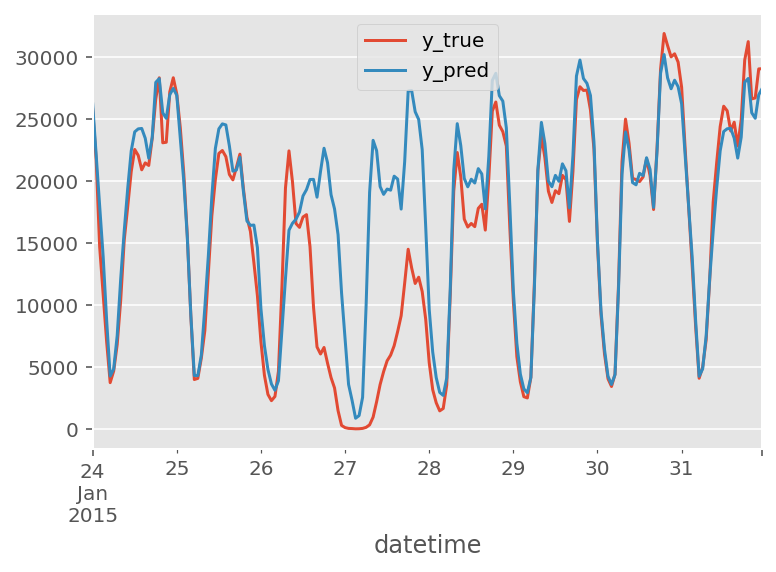

In [92]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();

### Zip Code별 차이

In [465]:
def visualize_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax = data.plot();
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 10200))

In [466]:
visualize_output_by_zipcode(test_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

### Hour별 차이

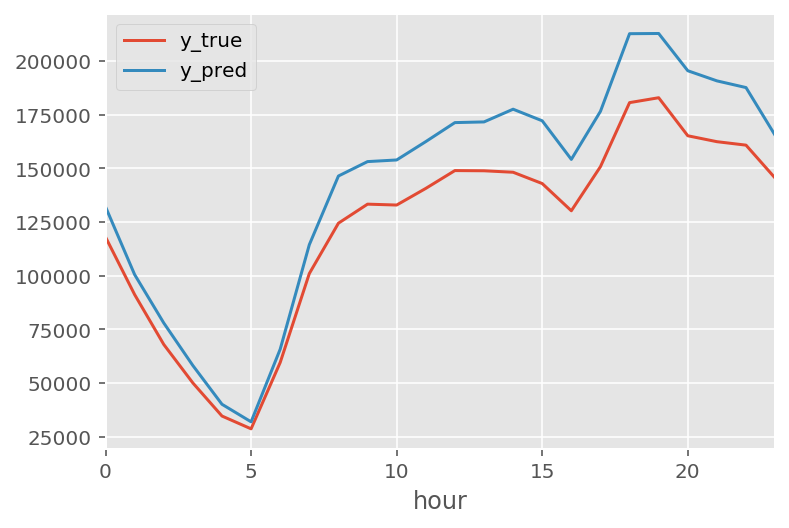

In [95]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot();

 전반적으로 높게 예측하며 뒤쪽으로 갈 수록 차이를 많이보임

In [96]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']]

,y_true,y_pred
hour,,
0,118017,132110.7
1,91196,100515.6
2,67973,77981.1
3,50021,58140.5
4,34603,40086.0
5,28638,31901.6
6,59575,65763.6
7,100996,114443.7
8,124475,146461.8


- 새벽 시간엔 거의 유사하다가 7시부터 20시까지 계속 차이가 남

### Weekday별 차이

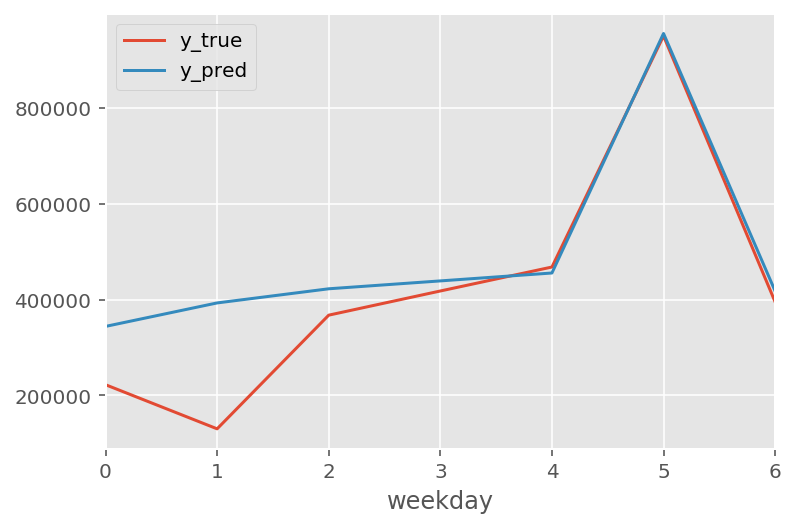

In [97]:
test_df[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot();

### 평일/주말별 차이

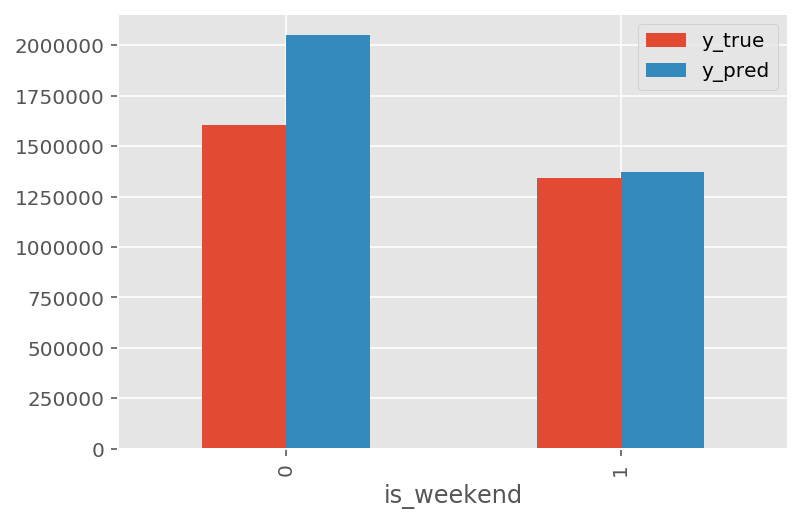

In [98]:
test_df[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar');

- 평일에 못맞추는 편, 주말에 잘 맞추는 편
    - 평일 중 특히 월화에 격차가 있음